In [2]:
import pandas as pd
import numpy as np
import datetime
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
from tensorflow import keras
import time
import tensorflow as tf

# Load Reddit comments

In [6]:
li = []
df1 = pd.read_csv('../Data/BitcoinSubredditComments/bitcoinsubreddit01.csv')
li.append(df1)
df2 = pd.read_csv('../Data/BitcoinSubredditComments/bitcoinsubreddit02.csv')
li.append(df2)
df3 = pd.read_csv('../Data/BitcoinSubredditComments/bitcoinsubreddit03.csv')
li.append(df3)
df4 = pd.read_csv('../Data/BitcoinSubredditComments/bitcoinsubreddit04.csv')
li.append(df4)
df5 = pd.read_csv('../Data/BitcoinSubredditComments/bitcoinsubreddit05.csv')
li.append(df5)
df6 = pd.read_csv('../Data/BitcoinSubredditComments/bitcoinsubreddit06.csv')
li.append(df6)

df = pd.concat(li, axis=0, ignore_index=True)

In [7]:
df["created_utc"] = pd.to_datetime(df["created_utc"],unit='s')

In [8]:
df["retrieved_on"] = pd.to_datetime(df["retrieved_on"],unit='s')

# Load BitCoin price history

In [10]:
dfprice = pd.read_csv('../Data/BitcoinPrice/bitcoinprice2020-21.csv')

In [11]:
dfprice["Date"] = pd.to_datetime(dfprice["Date"], infer_datetime_format=True)  

# Filter comments to correct date range and do necessary transformations

In [12]:
dfjune = df[df["created_utc"] >= '02/01/2021']

In [13]:
dfjune = dfjune[dfjune["created_utc"] < '07/01/2021']

In [14]:
dfjune["created_utc"] = pd.to_datetime(dfjune["created_utc"].dt.date)

In [15]:
dfjune["author_premium"] = dfjune["author_premium"].astype(int)

In [16]:
dfjune["locked"] = dfjune["locked"].astype(int)

In [17]:
dfjune["no_follow"] = dfjune["no_follow"].astype(int)

In [18]:
dfjune["quarantined"] = dfjune["quarantined"].astype(int)

# Filter BitCoin price data to appropriate data range

In [19]:
dfpricejune = dfprice[dfprice["Date"] >= '02/01/2021']

In [20]:
dfpricejune = dfpricejune[dfpricejune["Date"] < '07/01/2021']

# Filter out invalid comments

In [21]:
dfjunevalidcomments = dfjune[dfjune['body'] != "[removed]"]

In [22]:
dfjunevalidcomments = dfjunevalidcomments[dfjunevalidcomments['body'] != "[deleted]"]

# Get comment sentiment for each day (Skip this, go to Load Saved Sentiments)
## First get a sampleof 165 comments from each day

In [89]:
currentday = datetime.datetime(2021,2,1)

li = []
num = 28
for x in range(num):
    dfjuneday = dfjunevalidcomments[dfjunevalidcomments["created_utc"] == currentday].sample(n=165)
    li.append(dfjuneday)
    currentday = currentday + datetime.timedelta(days=1)
    
dfjunesample = pd.concat(li, axis=0, ignore_index=True)

## Trim comments to 5,120 characters

The service being used to get comment sentiment can only accept strings up to 5,120 characters so we need to trim any comments longer than that.

In [90]:
dfjunesample["body"] = dfjunesample["body"].str.slice(0,5120)

## Set the sentiment field to 'Not Set'

Sometimes getting sentiments has to be done in batches, this allows us to track which comments we have already gotten the sentiment for.

In [91]:
dfjunesample["sentiment"] = "Not Set"

## Setup method for getting sentiment

In [92]:
key = "{enter key here}"

In [93]:
endpoint = "https://masterssentiment.cognitiveservices.azure.com/"

In [94]:
from azure.ai.textanalytics import TextAnalyticsClient
from azure.core.credentials import AzureKeyCredential

def authenticate_client():
    ta_credential = AzureKeyCredential(key)
    text_analytics_client = TextAnalyticsClient(
            endpoint=endpoint, 
            credential=ta_credential)
    return text_analytics_client

client = authenticate_client()

In [110]:
dfjunesample[dfjunesample["sentiment"] == "Not Set"]

,author_premium,body,controversiality,created_utc,distinguished,id,locked,no_follow,parent_id,quarantined,removal_reason,retrieved_on,score,subreddit,sentiment


## Get the sentiment for the comments

In [109]:
for i in dfjunesample[dfjunesample["sentiment"] == "Not Set"].head(800).index:
    print(i)
    docs = dfjunesample.iloc[i][["body"]].values.tolist()
    response = client.analyze_sentiment(documents=docs)
    for r in response:
        dfjunesample.at[i, "sentiment"] = r.sentiment

## Create a separate field to count each sentiment

In [15]:
dfjunesample["PositiveSentiment"] = np.where(dfjunesample["sentiment"] == "positive", 1, 0)

In [16]:
dfjunesample["MixedSentiment"] = np.where(dfjunesample["sentiment"] == "mixed", 1, 0)

In [17]:
dfjunesample["NeutralSentiment"] = np.where(dfjunesample["sentiment"] == "neutral", 1, 0)

In [18]:
dfjunesample["NegativeSentiment"] = np.where(dfjunesample["sentiment"] == "negative", 1, 0)

## Save the comment sentiments
There is a cost involved in getting comment sentiments, so after getting the first time, save them.

In [120]:
dfjunesample.to_csv("commentsentiment.csv")

## Load saved sentiments
When repeating this script this is where you should start

In [23]:
dfcommsent = pd.read_csv("../Data/RedditCommentSentiment/commentsentiment.csv")

In [24]:
dfcommsent["created_utc"] = pd.to_datetime(dfcommsent["created_utc"], infer_datetime_format=True) 

In [25]:
dfcommsent

,Unnamed: 0,Unnamed: 0.1,author_premium,body,controversiality,created_utc,distinguished,id,locked,no_follow,...,NeutralSentiment,NegativeSentiment,Unnamed: 0.1.1,Unnamed: 0.1.1.1,Unnamed: 0.1.1.1.1,Unnamed: 0.1.1.1.1.1,Unnamed: 0.1.1.1.1.1.1,Unnamed: 0.1.1.1.1.1.1.1,Unnamed: 0.1.1.1.1.1.1.1.1,Unnamed: 0.1.1.1.1.1.1.1.1.1
0,0,0,0,"oh, you know why they want to know.",0,2021-02-01,NaN,glkajf5,0,1,...,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,0,lmao this is great,0,2021-02-01,NaN,glm0x2k,0,0,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2,0,Goosebump.,0,2021-02-01,NaN,glmw4xr,0,0,...,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,3,0,just the gay mods,0,2021-02-01,NaN,glnpl7y,0,0,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,4,1,If you look at the trend of the price right no...,0,2021-02-01,NaN,glktbrz,0,1,...,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24745,24745,20125,0,"What a cracker, thanks.\n\nWell worth the read...",0,2021-06-30,NaN,h3ioicu,0,1,...,0,0,15010.0,10060.0,4945.0,4945.0,4945.0,NaN,NaN,NaN
24746,24746,20126,0,"Right, those restrictions are only for direct ...",0,2021-06-30,NaN,h3k6jj6,0,0,...,0,1,15011.0,10061.0,4946.0,4946.0,4946.0,NaN,NaN,NaN
24747,24747,20127,0,"Oh it's so true, and it's gambling short term ...",0,2021-06-30,NaN,h3iypnx,0,1,...,0,0,15012.0,10062.0,4947.0,4947.0,4947.0,NaN,NaN,NaN
24748,24748,20128,0,Why aren't we doing this with Niagara Falls?,0,2021-06-30,NaN,h3ja80z,0,0,...,0,1,15013.0,10063.0,4948.0,4948.0,4948.0,NaN,NaN,NaN


# Get comment aggregations by day

In [21]:
dfjune.describe()

,author_premium,controversiality,locked,no_follow,quarantined,removal_reason,score
count,1.296999e+06,1.296999e+06,1.296999e+06,1.296999e+06,1296999.0,0.0,1.296999e+06
mean,4.496380e-02,2.010025e-02,3.315346e-05,6.914385e-01,0.0,NaN,3.651674e+00
std,2.072247e-01,1.403433e-01,5.757811e-03,4.618999e-01,0.0,NaN,2.161691e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,NaN,-1.520000e+02
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,NaN,1.000000e+00
50%,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.0,NaN,1.000000e+00
75%,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.0,NaN,3.000000e+00
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.0,NaN,7.575000e+03


In [22]:
dfjunebyday = dfjune[["created_utc","id","author_premium","controversiality", "locked", "no_follow", "score"]].groupby(["created_utc"]).agg({"id": ["count"], "author_premium": ["sum"], "controversiality": ["sum"], "locked" : ["sum"], "no_follow" : ["sum"], "score" : [np.mean]})

In [23]:
dfjunebyday = dfjunebyday.droplevel(axis=1, level=0).reset_index().set_axis(["Date", "CommentCount", "PremiumCount", "Controversiality", "LockedCount", "FollowCount", "Score"], axis=1, inplace=False)

In [24]:
dfjunebyday

,Date,CommentCount,PremiumCount,Controversiality,LockedCount,FollowCount,Score
0,2021-02-01,7078,399,97,0,5156,3.187482
1,2021-02-02,6805,375,66,0,4701,3.506392
2,2021-02-03,6960,351,69,0,4693,3.675287
3,2021-02-04,8392,392,118,0,5943,4.259414
4,2021-02-05,7534,353,138,0,5597,2.944518
...,...,...,...,...,...,...,...
145,2021-06-26,6170,250,183,0,4457,2.897893
146,2021-06-27,5626,269,121,0,3998,3.302524
147,2021-06-28,5447,315,105,0,3945,3.651735
148,2021-06-29,6025,334,191,0,4111,3.398506


# Aggregate sentiment by day

In [25]:
sentimentbyday = dfcommsent[["created_utc", "id", "PositiveSentiment", "MixedSentiment", "NeutralSentiment", "NegativeSentiment"]].groupby(["created_utc"]).agg({"id": ["count"], "PositiveSentiment" : ["sum"], "MixedSentiment" : ["sum"], "NeutralSentiment" : ["sum"], "NegativeSentiment" : ["sum"]})

In [26]:
sentimentbyday = sentimentbyday.droplevel(axis=1, level=0).reset_index().set_axis(["Date", "Count", "PositiveCount", "MixedCount", "NeutralCount", "NegativeCount"], axis=1, inplace=False)

In [27]:
sentimentbyday["PositivePerc"] = sentimentbyday["PositiveCount"]/sentimentbyday["Count"]

In [28]:
sentimentbyday["MixedPerc"] = sentimentbyday["MixedCount"]/sentimentbyday["Count"]

In [29]:
sentimentbyday["NeutralPerc"] = sentimentbyday["NeutralCount"]/sentimentbyday["Count"]

In [30]:
sentimentbyday["NegativePerc"] = sentimentbyday["NegativeCount"]/sentimentbyday["Count"]

In [31]:
sentimentbyday = sentimentbyday[["Date", "PositivePerc", "MixedPerc", "NeutralPerc", "NegativePerc"]]

# Combine the comment, sentiment, and price dataframes

In [32]:
dfjunewithprice = pd.merge(dfjunebyday, dfpricejune, left_on="Date", right_on="Date", how="outer")

In [33]:
dfbitcoin = pd.merge(dfjunewithprice, sentimentbyday, left_on="Date", right_on="Date", how="outer")

In [34]:
dfbitcoin

,Date,CommentCount,PremiumCount,Controversiality,LockedCount,FollowCount,Score,Price,Open,High,Low,Vol.,Change %,PositivePerc,MixedPerc,NeutralPerc,NegativePerc
0,2021-02-01,7078,399,97,0,5156,3.187482,"33,515.7","33,106.8","34,685.6","32,324.9",126.32K,1.23%,0.315152,0.133333,0.309091,0.242424
1,2021-02-02,6805,375,66,0,4701,3.506392,"35,485.2","33,514.0","35,976.1","33,462.4",120.85K,5.88%,0.278788,0.133333,0.315152,0.272727
2,2021-02-03,6960,351,69,0,4693,3.675287,"37,646.8","35,486.9","37,646.8","35,401.5",131.03K,6.09%,0.206061,0.145455,0.351515,0.296970
3,2021-02-04,8392,392,118,0,5943,4.259414,"36,982.1","37,648.9","38,707.9","36,380.8",151.44K,-1.77%,0.248485,0.133333,0.303030,0.315152
4,2021-02-05,7534,353,138,0,5597,2.944518,"38,297.6","36,976.4","38,303.6","36,640.0",100.60K,3.56%,0.236364,0.115152,0.339394,0.309091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,2021-06-26,6170,250,183,0,4457,2.897893,"32,243.4","31,592.1","32,643.0","30,206.9",156.67K,2.06%,0.175758,0.169697,0.339394,0.315152
146,2021-06-27,5626,269,121,0,3998,3.302524,"34,678.5","32,247.1","34,685.5","32,041.7",148.80K,7.55%,0.278788,0.115152,0.284848,0.321212
147,2021-06-28,5447,315,105,0,3945,3.651735,"34,475.9","34,682.2","35,231.2","33,944.9",112.00K,-0.58%,0.248485,0.096970,0.387879,0.266667
148,2021-06-29,6025,334,191,0,4111,3.398506,"35,834.7","34,477.3","36,590.3","34,247.6",97.27K,3.94%,0.254545,0.133333,0.290909,0.321212


# Transform the data
## Get the next day change %

In [36]:
dfbitcoin["Change %"] = dfbitcoin["Change %"].str.rstrip('%').astype('float') / 100.0

In [37]:
dfbitcoin["NextDayChange"] = dfbitcoin["Change %"].shift(-1)

In [38]:
dfbitcoin = dfbitcoin.dropna().copy()

## Categorize the data base on what the change was

In [39]:
conditions = [
               (dfbitcoin["NextDayChange"] <= -0.025), 
               (dfbitcoin["NextDayChange"] > -0.025) & (dfbitcoin["NextDayChange"] < 0.025),
               (dfbitcoin["NextDayChange"] >= 0.025)
             ]
values = [0, 1, 2]
dfbitcoin['ChangeGroup'] = np.select(conditions, values)

## Trim it down to just the columns we are interested in

In [40]:
dfbitcoin = dfbitcoin[["CommentCount", "PremiumCount", "Controversiality", "FollowCount", "Score", "PositivePerc", "NegativePerc", "ChangeGroup"]].copy()

In [41]:
dfbitcoin

,CommentCount,PremiumCount,Controversiality,FollowCount,Score,PositivePerc,NegativePerc,ChangeGroup
0,7078,399,97,5156,3.187482,0.315152,0.242424,2
1,6805,375,66,4701,3.506392,0.278788,0.272727,2
2,6960,351,69,4693,3.675287,0.206061,0.296970,1
3,8392,392,118,5943,4.259414,0.248485,0.315152,2
4,7534,353,138,5597,2.944518,0.236364,0.309091,2
...,...,...,...,...,...,...,...,...
144,7494,295,210,5382,3.987990,0.212121,0.321212,1
145,6170,250,183,4457,2.897893,0.175758,0.315152,2
146,5626,269,121,3998,3.302524,0.278788,0.321212,1
147,5447,315,105,3945,3.651735,0.248485,0.266667,2


## Scale the data

In [42]:
dfbitcoin["CommentCount"] = dfbitcoin["CommentCount"] / 35000

In [43]:
dfbitcoin["PremiumCount"] = dfbitcoin["PremiumCount"] / 1000

In [44]:
dfbitcoin["FollowCount"] = dfbitcoin["FollowCount"] / 25000

In [45]:
dfbitcoin["Score"] = dfbitcoin["Score"] / 6

# Create train, test, and validation data sets

In [46]:
bitcoin_train, bitcoin_test = train_test_split(dfbitcoin, test_size=0.4)

In [47]:
bitcoin_test, bitcoin_valid = train_test_split(bitcoin_test, test_size=0.5)

In [48]:
X_train = bitcoin_train[["CommentCount", "PremiumCount", "Controversiality", "FollowCount", "Score", "PositivePerc", "NegativePerc"]].to_numpy()

In [49]:
y_train = bitcoin_train[["ChangeGroup"]].to_numpy()

In [50]:
X_test = bitcoin_test[["CommentCount", "PremiumCount", "Controversiality", "FollowCount", "Score", "PositivePerc", "NegativePerc"]].to_numpy()

In [51]:
y_test = bitcoin_test[["ChangeGroup"]].to_numpy()

In [52]:
X_valid = bitcoin_valid[["CommentCount", "PremiumCount", "Controversiality", "FollowCount", "Score", "PositivePerc", "NegativePerc"]].to_numpy()

In [53]:
y_valid = bitcoin_valid[["ChangeGroup"]].to_numpy()

# Analyze Train Data

In [54]:
cgdf = bitcoin_train[["ChangeGroup"]].copy()

In [55]:
cgdf["Change Group"] = ""

In [56]:
cgdf.loc[cgdf['ChangeGroup'] == 0, 'Change Group'] = "Decrease"
cgdf.loc[cgdf['ChangeGroup'] == 1, 'Change Group'] = "No Change"
cgdf.loc[cgdf['ChangeGroup'] == 2, 'Change Group'] = "Increase"

Text(0, 0.5, '')

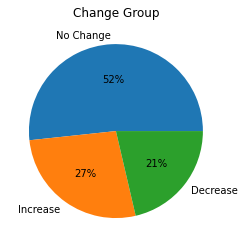

In [57]:
ax = cgdf["Change Group"].value_counts().plot.pie(autopct='%1.0f%%', title="Change Group", legend=False)
ax.set_ylabel('')

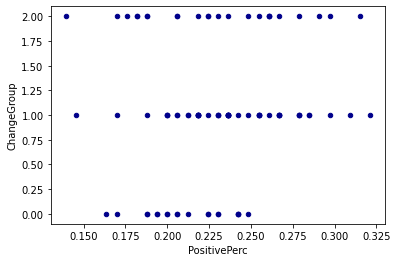

In [58]:
ax1 = bitcoin_train.plot.scatter(x='PositivePerc', y='ChangeGroup', c='DarkBlue')

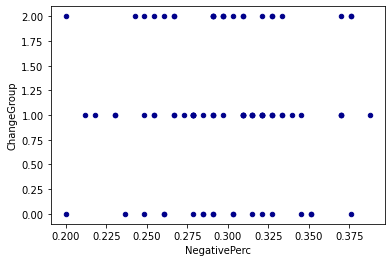

In [59]:
ax1 = bitcoin_train.plot.scatter(x='NegativePerc', y='ChangeGroup', c='DarkBlue')

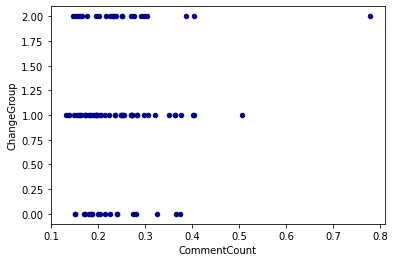

In [60]:
ax1 = bitcoin_train.plot.scatter(x='CommentCount', y='ChangeGroup', c='DarkBlue')

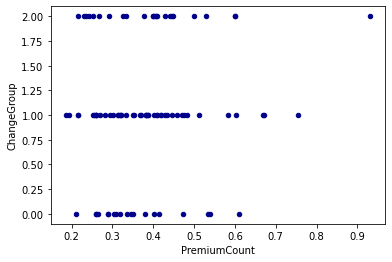

In [61]:
ax1 = bitcoin_train.plot.scatter(x='PremiumCount', y='ChangeGroup', c='DarkBlue')

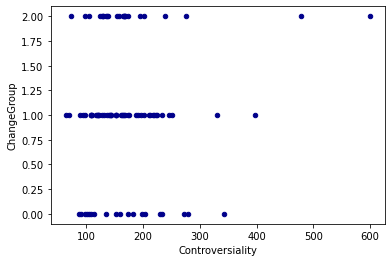

In [62]:
ax1 = bitcoin_train.plot.scatter(x='Controversiality', y='ChangeGroup', c='DarkBlue')

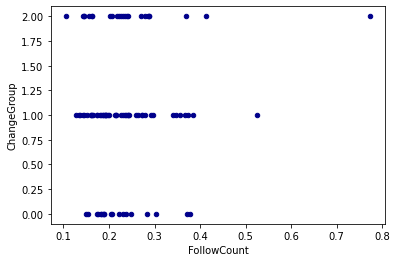

In [63]:
ax1 = bitcoin_train.plot.scatter(x='FollowCount', y='ChangeGroup', c='DarkBlue')

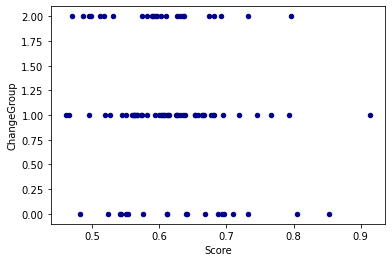

In [64]:
ax1 = bitcoin_train.plot.scatter(x='Score', y='ChangeGroup', c='DarkBlue')

# Create Model

In [65]:
root_logdir = os.path.join(os.curdir, "tensor_logs")
def get_run_logdir():
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

In [66]:
model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[7,]))
model.add(keras.layers.Dense(10, activation="relu"))
model.add(keras.layers.Dense(3, activation="softmax"))

In [67]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                80        
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 33        
Total params: 113
Trainable params: 113
Non-trainable params: 0
_________________________________________________________________


In [68]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd", metrics=["accuracy"])

In [71]:
run_logdir = get_run_logdir()
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
history = model.fit(X_train, y_train, epochs=60, validation_data=(X_valid, y_valid), callbacks=[tensorboard_cb])

Epoch 1/60
3/3 [==============================] - 0s 66ms/step - loss: 1.0445 - accuracy: 0.5169 - val_loss: 0.9926 - val_accuracy: 0.6667
Epoch 2/60
3/3 [==============================] - 0s 15ms/step - loss: 1.0440 - accuracy: 0.5169 - val_loss: 0.9916 - val_accuracy: 0.6667
Epoch 3/60
3/3 [==============================] - 0s 17ms/step - loss: 1.0436 - accuracy: 0.5169 - val_loss: 0.9906 - val_accuracy: 0.6667
Epoch 4/60
3/3 [==============================] - 0s 17ms/step - loss: 1.0432 - accuracy: 0.5169 - val_loss: 0.9896 - val_accuracy: 0.6667
Epoch 5/60
3/3 [==============================] - 0s 17ms/step - loss: 1.0427 - accuracy: 0.5169 - val_loss: 0.9886 - val_accuracy: 0.6667
Epoch 6/60
3/3 [==============================] - 0s 17ms/step - loss: 1.0424 - accuracy: 0.5169 - val_loss: 0.9877 - val_accuracy: 0.6667
Epoch 7/60
3/3 [==============================] - 0s 15ms/step - loss: 1.0420 - accuracy: 0.5169 - val_loss: 0.9868 - val_accuracy: 0.6667
Epoch 8/60
3/3 [===========

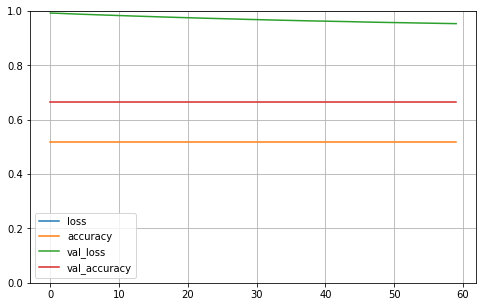

In [72]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [73]:
model.evaluate(X_test, y_test)

1/1 [==============================] - 0s 19ms/step - loss: 1.1447 - accuracy: 0.3000


[1.1447272300720215, 0.30000001192092896]

In [80]:
y_proba = model.predict(X_test)
indexes = tf.argmax(y_proba, axis=1)
indexes

<tf.Tensor: shape=(30,), dtype=int64, numpy=
array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)>

In [81]:
resultdf = pd.DataFrame(indexes)
resultdf["Change Group"] = "Unknown"
resultdf.loc[resultdf[0] == 0, 'Change Group'] = "Decrease"
resultdf.loc[resultdf[0] == 1, 'Change Group'] = "No Change"
resultdf.loc[resultdf[0] == 2, 'Change Group'] = "Increase"

Text(0, 0.5, '')

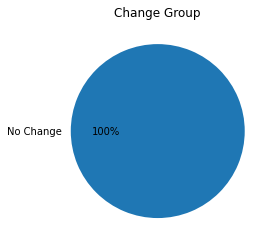

In [82]:
ax = resultdf["Change Group"].value_counts().plot.pie(autopct='%1.0f%%', title="Change Group", legend=False)
ax.set_ylabel('')

In [76]:
y_proba = model.predict(X_test)
y_proba.round(2)

array([[0.25, 0.47, 0.28],
       [0.25, 0.47, 0.28],
       [0.25, 0.47, 0.28],
       [0.25, 0.47, 0.28],
       [0.25, 0.47, 0.28],
       [0.25, 0.47, 0.28],
       [0.25, 0.47, 0.28],
       [0.25, 0.47, 0.28],
       [0.25, 0.47, 0.28],
       [0.25, 0.47, 0.28],
       [0.25, 0.47, 0.28],
       [0.25, 0.47, 0.28],
       [0.25, 0.47, 0.28],
       [0.25, 0.47, 0.28],
       [0.25, 0.47, 0.28],
       [0.25, 0.47, 0.28],
       [0.25, 0.47, 0.28],
       [0.25, 0.47, 0.28],
       [0.25, 0.47, 0.28],
       [0.25, 0.47, 0.28],
       [0.25, 0.47, 0.28],
       [0.25, 0.47, 0.28],
       [0.25, 0.47, 0.28],
       [0.25, 0.47, 0.28],
       [0.25, 0.47, 0.28],
       [0.25, 0.47, 0.28],
       [0.25, 0.47, 0.28],
       [0.25, 0.47, 0.28],
       [0.25, 0.47, 0.28],
       [0.25, 0.47, 0.28]], dtype=float32)

In [75]:
X_test

array([[2.15257143e-01, 3.53000000e-01, 1.38000000e+02, 2.23880000e-01,
        4.90753031e-01, 2.36363636e-01, 3.09090909e-01],
       [4.08771429e-01, 4.99000000e-01, 4.31000000e+02, 4.08200000e-01,
        4.91647445e-01, 1.75757576e-01, 3.81818182e-01],
       [2.12257143e-01, 3.24000000e-01, 1.95000000e+02, 2.07800000e-01,
        9.17866918e-01, 2.42424242e-01, 3.51515152e-01],
       [1.94428571e-01, 3.75000000e-01, 6.60000000e+01, 1.88040000e-01,
        5.84398726e-01, 2.78787879e-01, 2.72727273e-01],
       [2.18085714e-01, 3.80000000e-01, 1.49000000e+02, 2.16480000e-01,
        5.61924101e-01, 1.81818182e-01, 3.81818182e-01],
       [2.61428571e-01, 4.09000000e-01, 1.74000000e+02, 2.47760000e-01,
        6.20491803e-01, 2.54545455e-01, 3.15151515e-01],
       [1.61085714e-01, 3.21000000e-01, 1.29000000e+02, 1.62120000e-01,
        5.20160814e-01, 2.66666667e-01, 3.57575758e-01],
       [1.96285714e-01, 2.78000000e-01, 1.67000000e+02, 1.94680000e-01,
        4.95220767e-01, 2